In [112]:
%run imports.py

/home/juan/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Ejemplo de red similar a la nuestra

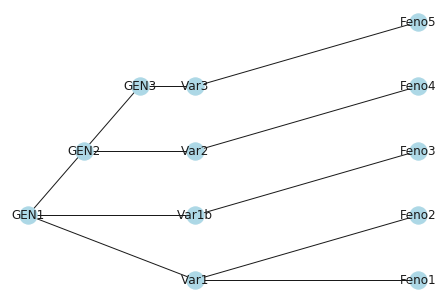

In [168]:
random.seed(42)

enlaces = [
    # Entramos por el Feno1
    ("Feno1", "Var1"),
    
    # Misma variante, dos fenos
    ("Var1", "Feno2"), 
    
    # Mismo gen, dos variantes, dos fenos
    ("Var1", "GEN1"), ("GEN1", "Var1b"), ("Var1b", "Feno3"),
    
    # Dos genes (grado sep 1), dos variantes, dos fenos
    ("GEN1", "GEN2"), ("GEN2", "Var2"), ("Var2", "Feno4"),
    
    # Dos genes (grado sep 2), dos variantes, dos fenos
    ("GEN2", "GEN3"), ("GEN3", "Var3"), ("Var3", "Feno5")
]

## Creación de la red a partir de los enlaces:

red = nx.Graph()
red.add_edges_from(enlaces)

def deducir_tipo(nodo):
    return {"Fen": "fenotipo", "GEN": "gen", "Var": "variante"}[nodo[:3]]

tipo_de_nodos = {nodo: deducir_tipo(nodo) for nodo in red.nodes()}
nx.set_node_attributes(red, tipo_de_nodos, name="tipo")

genes = [node for node, attrs in red.nodes(data=True) if attrs["tipo"] == "gen"]
fenos = [node for node, attrs in red.nodes(data=True) if attrs["tipo"] == "fenotipo"]
variantes = [node for node, attrs in red.nodes(data=True) if attrs["tipo"] == "variante"]

## Posiciones en el gráfico:

pos_genes = {
    gen: (i+1, i+1)
    for i, gen in enumerate(genes)
}
pos_variantes = {
    variante: (len(genes)+1, i)
    for i, variante in enumerate(variantes)
}
pos_fenos = {
    feno: (len(genes)+5, i)
    for i, feno in enumerate(fenos)
}
posiciones = {**pos_genes, **pos_variantes, **pos_fenos}

nx.draw(red, pos=posiciones, node_color="lightblue", with_labels=True)
plt.show()

## Priorización
  
  * Relacion FVF: `Feno1` -> `Feno2`
  * Relacion FV(G)VF: `Feno1` -> `Feno3`
  * Relacion FV(G-G)VF: `Feno1` -> `Feno4`
  * Relacion FV(G-G-G)VF: `Feno1` -> `Feno5`

Label Spreading: The method stopped after 33 iterations, variation=0.0009.


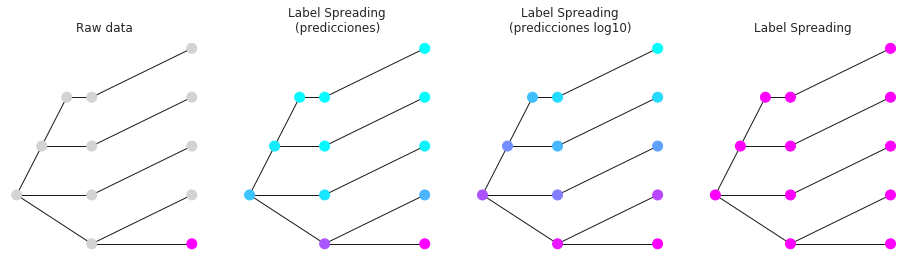

In [182]:
import utils

nodo_entrada = 'Feno1'

adj_matrix = nx.adjacency_matrix(red).toarray()
labels = [
    0 if nodo == nodo_entrada else -1
    for nodo in red.nodes()
]

# Create input tensors
adj_matrix_t = torch.FloatTensor(adj_matrix)
labels_t = torch.LongTensor(labels)

# Label Spreading
label_spreading = utils.LabelSpreading(adj_matrix_t)
print("Label Spreading: ", end="")
label_spreading.fit(labels_t, alpha=.8)
label_spreading_output_labels = label_spreading.predict_classes()

# Plot

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

ax1.title.set_text("Raw data")
ax2.title.set_text("Label Spreading\n(predicciones)")
ax3.title.set_text("Label Spreading\n(predicciones log10)")
ax4.title.set_text("Label Spreading")

color_map = {-1: "lightgrey", 0: "fuchsia"}
input_labels_colors = [color_map[l] for l in labels]
nx.draw(red, ax=ax1, pos=posiciones, node_color=input_labels_colors, node_size=100)

prediction_raw_values = list(flatten(label_spreading.predictions.tolist()))
nx.draw(red, ax=ax2, pos=posiciones, node_color=prediction_raw_values, cmap=cm.cool, node_size=100)

prediction_log_values = np.log10(prediction_raw_values)
nx.draw(red, ax=ax3, pos=posiciones, node_color=prediction_log_values, cmap=cm.cool, node_size=100)

lspread_labels_colors = [color_map[l] for l in label_spreading_output_labels.numpy()]
nx.draw(red, ax=ax4, pos=posiciones, node_color=lspread_labels_colors, node_size=100)

plt.show()

In [183]:
predicciones_raw = {nodo: pred for nodo, pred in zip(red.nodes(), prediction_raw_values)
                    if deducir_tipo(nodo) == 'fenotipo'}
predicciones_raw

{'Feno1': 0.289326548576355,
 'Feno2': 0.08932653069496155,
 'Feno3': 0.018861472606658936,
 'Feno4': 0.007182623725384474,
 'Feno5': 0.003719902131706476}